<img src="../../../../images/python-distribution-package-tabclass.png"/>

## Set Variables

In [90]:
PROJECT_ID = 'jchavezar-demo' # @param {type:"string"}
REGION = 'us-central1' # @param {type:"string"}
#DATASETS_URI = 'gs://vtx-datasets-public/ecommerce' # @param {type:"string"}
MODEL_URI = 'gs://vtx-models/flower_photos/tpu' # @param {type:"string"}
STAGING_URI = 'gs://vtx-staging/flower_photos/tpu' # @param {type:"string"}
TRAIN_IMAGE_URI = 'us-docker.pkg.dev/vertex-ai/training/tf-tpu.2-8:latest' # @param {type:"string"}
PREDICTION_IMAGE_URI = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest' # @param {type:"string"}

## Import Libraries

In [91]:
from google.cloud import aiplatform as aip

## Training Code Wrap it in Python Distribution Package File 

In [92]:
!rm -fr source
!mkdir -p source/trainer
!touch source/trainer/__init__.py

In [93]:
%%writefile source/trainer/train.py
import os, sys, math
import numpy as np
import tensorflow as tf
import pickle
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

try: # detect TPUs
    #tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    #strategy = tf.distribute.TPUStrategy(tpu)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    tpu = ""
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

GCS_PATTERN = 'gs://vtx-datasets-public/flower_photos_tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
    BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
    BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE

## Utils
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    
    return numpy_images, numpy_labels


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
        tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])
    model.summary()
    
    EPOCHS = 20
    
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                        validation_data=validation_dataset)
    model.save(os.environ['AIP_MODEL_DIR'])
    
    #Storing metrics/artifacts
    print(os.listdir('/gcs/vtx-models/'))

    with open('/gcs/vtx-models/flower_photos/tpu/metrics', 'wb') as file:
        pickle.dump(history.history,  file)

Writing source/trainer/train.py


In [94]:
%%writefile source/setup.py
from setuptools import setup
from setuptools import find_packages

setup(
    name = 'trainer',
    packages = find_packages(),
    description='Training Package'
)

Writing source/setup.py


In [95]:
!rm -f source.tar source.tar.gz
!tar cvf source.tar source
!gzip source.tar
# Copy python package with training code to Google Cloud Storage
!gsutil cp source.tar.gz {MODEL_URI}/packages/source.tar.gz

source/
source/trainer/
source/trainer/__init__.py
source/trainer/train.py
source/setup.py
Copying file://source.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                
Operation completed over 1 objects/2.4 KiB.                                      


## Vertex AI Training Using CustomJob

*More Information about CustoJob Library here: https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.CustomJob*

*For worker_pool_specs definition: https://cloud.google.com/vertex-ai/docs/reference/rest/v1/CustomJobSpec#WorkerPoolSpec*

In [96]:
# Initialize Vertex
aip.init(project=PROJECT_ID)

# Job Definition
worker_pool_specs = [
    {
        'machine_spec' : {
            'machine_type': 'cloud-tpu',
            'accelerator_type': 'TPU_V2',
            'accelerator_count': 8
        },
        'replica_count': 1,
        'python_package_spec': {
            'executor_image_uri': TRAIN_IMAGE_URI,
            'package_uris': [MODEL_URI+'/packages/source.tar.gz'],
            'python_module': 'trainer.train',
        }
    }
]

job = aip.CustomJob(
    display_name = 'flower_photos_tf-tpu',
    worker_pool_specs = worker_pool_specs,
    base_output_dir = MODEL_URI,
    staging_bucket = STAGING_URI
)

# Job Execution
model = job.run()

/home/sockcop/.local/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Creating CustomJob
CustomJob created. Resource name: projects/569083142710/locations/us-central1/customJobs/8839688245932457984
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/569083142710/locations/us-central1/customJobs/8839688245932457984')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8839688245932457984?project=569083142710
CustomJob projects/569083142710/locations/us-central1/customJobs/8839688245932457984 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/8839688245932457984 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/8839688245932457984 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/8839688245932457984 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/8839688

## Evaluation with Artifacts Stored in Google Cloud Storage

In [97]:
!gsutil cp gs://vtx-models/flower_photos/tpu/metrics /tmp/history

Copying gs://vtx-models/flower_photos/tpu/metrics...
/ [1 files][  796.0 B/  796.0 B]                                                
Operation completed over 1 objects/796.0 B.                                      


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


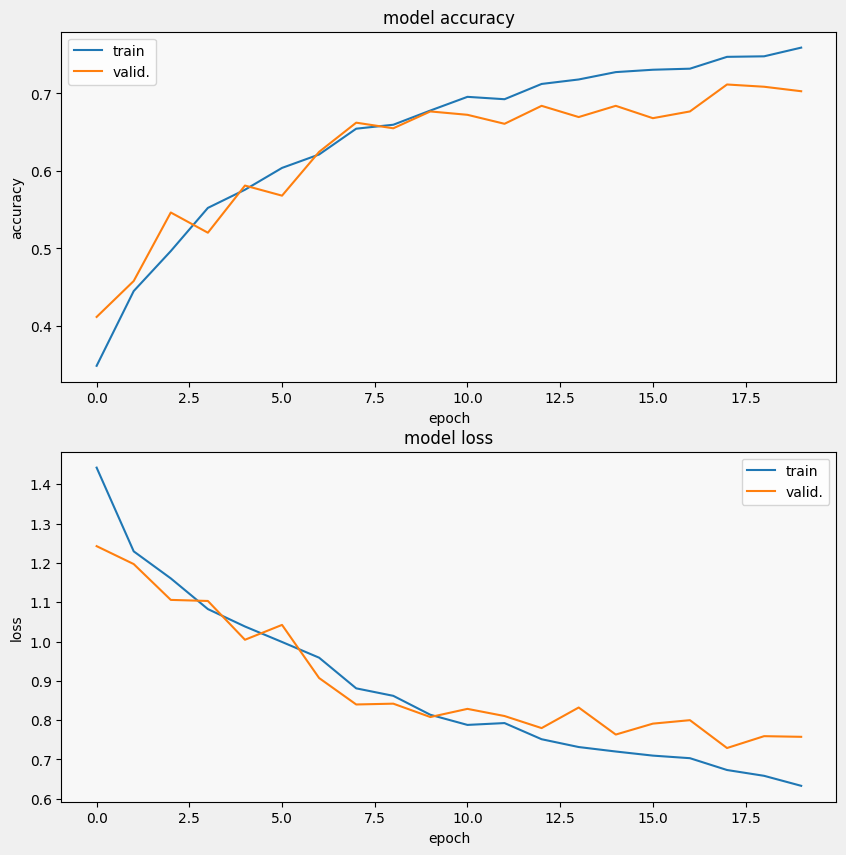

In [98]:
import pickle
from utilities.display import training_curves

with open('/tmp/history', 'rb') as  f:
    history = pickle.load(f)

print(history.keys())
training_curves(history['accuracy'], history['val_accuracy'], 'accuracy', 211)
training_curves(history['loss'], history['val_loss'], 'loss', 212)

## Upload Model to Model Registry

In [99]:
model_reg = aip.Model.upload(
    display_name = 'flower_photos_tf-tpu',
    serving_container_image_uri = PREDICTION_IMAGE_URI,
    artifact_uri = f'{MODEL_URI}/model',
)

/home/sockcop/.local/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Creating Model
Create Model backing LRO: projects/569083142710/locations/us-central1/models/5513868294366429184/operations/8565211866891026432


/home/sockcop/.local/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/sockcop/.local/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accoun

Model created. Resource name: projects/569083142710/locations/us-central1/models/5513868294366429184@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/5513868294366429184@1')


## Deploy Model for Online Predictions

In [ ]:
endpoint = model_reg.deploy(
    deployed_model_display_name = 'flower_photos_tf_ep_dep-v1',
    traffic_percentage = 100,
    machine_type = 'n1-standard-4',
    min_replica_count = 1,
    max_replica_count = 1,
)

## Transforming Data for Prediction

In [1]:
from utilities import data_transform as dt

some_flowers, some_labels = dt.dataset_to_numpy_util(dt.load_dataset(dt.validation_filenames), 160)

2023-03-03 23:16:50.894438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 23:16:51.071983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-03 23:16:51.072020: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-03 23:16:51.877081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
!gsutil ls gs://vtx-models/flower_photos/tpu/model

gs://vtx-models/flower_photos/tpu/model/
gs://vtx-models/flower_photos/tpu/model/keras_metadata.pb
gs://vtx-models/flower_photos/tpu/model/saved_model.pb
gs://vtx-models/flower_photos/tpu/model/assets/
gs://vtx-models/flower_photos/tpu/model/variables/


In [3]:
import tensorflow as tf

model = tf.keras.models.load_model('gs://vtx-models/flower_photos/tpu/model')

In [4]:
import numpy as np

# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(160)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)

10/10 [==============================] - 2s 135ms/step


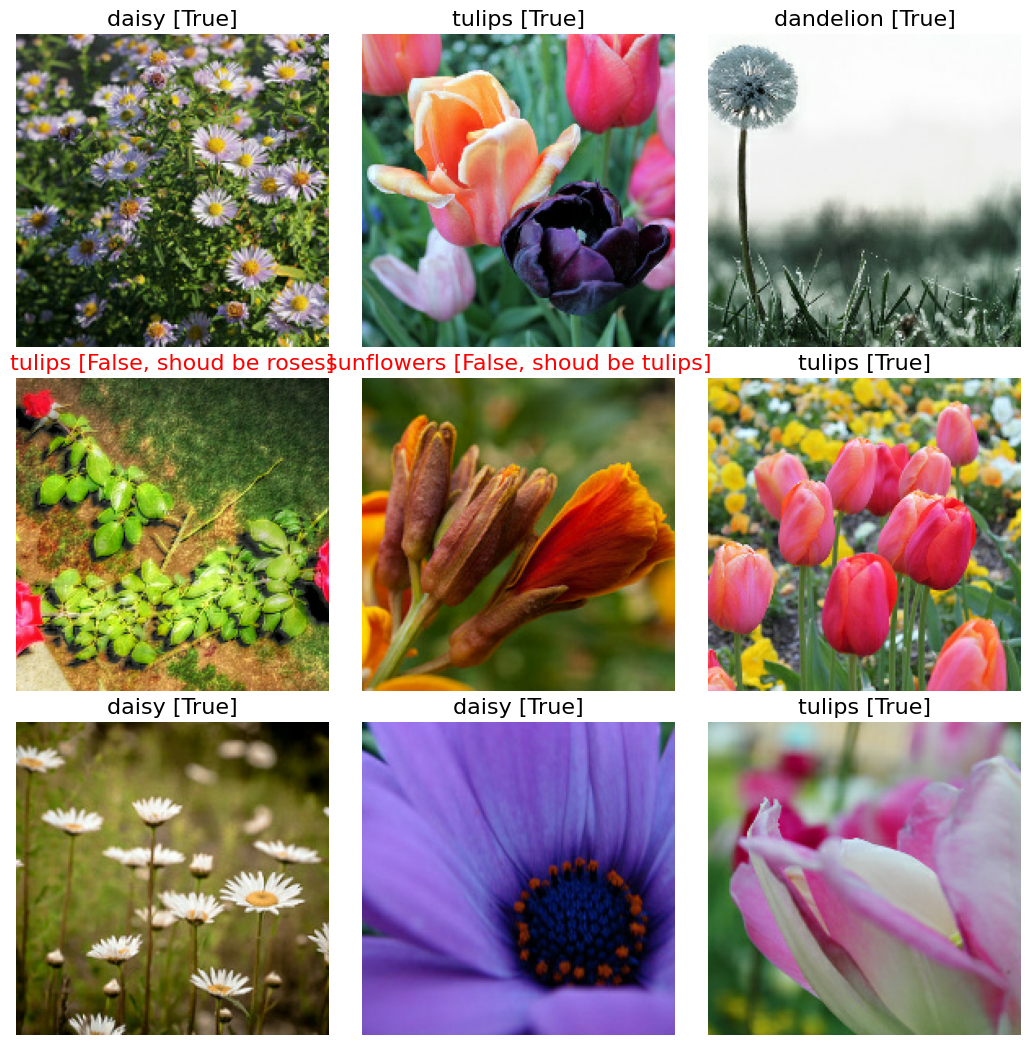

In [5]:
from utilities import display

display.display_9_images_with_predictions(some_flowers, predictions, some_labels)